##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 이미지 로드 및 전처리하기

<table class="tfo-notebook-buttons" align="left">
  <td>TensorFlow.org에서 보기</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a> </td>
  <td>GitHub에서 소스 보기</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운론드하기</a></td>
</table>

이 튜토리얼에서는 세 가지 방법으로 이미지 데이터세트를 로드하고 전처리하는 방법을 보여줍니다.

- 먼저 고급 Keras 사전 처리 유틸리티(예: `tf.keras.utils.image_dataset_from_directory`) 및 레이어(예: `tf.keras.layers.Rescaling`)를 사용하여 디스크에서 이미지 디렉터리를 읽습니다.
- 다음으로 [tf.data를 사용하여](../../guide/data.ipynb) 처음부터 고유한 입력 파이프라인을 작성합니다.
- 마지막으로 [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview)에서 사용할 수 있는 대규모 [카탈로그](https://www.tensorflow.org/datasets)에서 데이터세트를 다운로드합니다.

## 설정

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2022-12-14 21:02:22.685311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:02:22.685432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:02:22.685442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
print(tf.__version__)

2.11.0


### 꽃 데이터세트 다운로드하기

이 튜토리얼은 수천 장의 꽃 사진 데이터세트를 사용합니다. 꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉터리가 있습니다.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

참고: 모든 이미지에는 CC-BY 라이선스가 있으며 크리에이터는 LICENSE.txt 파일에 나열됩니다.

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

     8192/228813984 [..............................] - ETA: 0s

  9068544/228813984 [>.............................] - ETA: 1s

 21544960/228813984 [=>............................] - ETA: 0s

 34234368/228813984 [===>..........................] - ETA: 0s

 46039040/228813984 [=====>........................] - ETA: 0s

 59883520/228813984 [======>.......................] - ETA: 0s

 72376320/228813984 [========>.....................] - ETA: 0s

 77078528/228813984 [=========>....................] - ETA: 0s

 84172800/228813984 [==========>...................] - ETA: 0s

 92848128/228813984 [===========>..................] - ETA: 0s

103464960/228813984 [============>.................] - ETA: 0s

114221056/228813984 [=============>................] - ETA: 0s

126640128/228813984 [===============>..............] - ETA: 0s

140525568/228813984 [=================>............] - ETA: 0s

154394624/228813984 [===================>..........] - ETA: 0s

168722432/228813984 [=====================>........] - ETA: 0s

183115776/228813984 [=======================>......] - ETA: 0s

198148096/228813984 [========================>.....] - ETA: 0s

212713472/228813984 [==========================>...] - ETA: 0s

226852864/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


다운로드한 후 (218MB), 이제 꽃 사진의 사본을 사용할 수 있습니다. 총 3670개의 이미지가 있습니다.

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있습니다. 다음은 장미입니다.

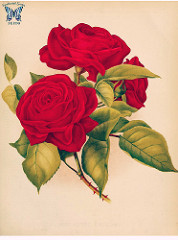

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

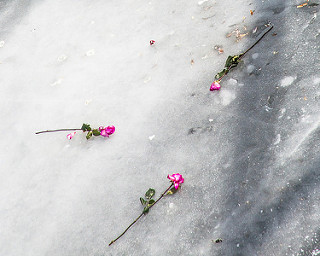

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Keras 유틸리티를 사용하여 데이터 로드

유용한 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 디스크에서 이러한 이미지를 로드해 보겠습니다.

### 데이터세트 만들기

로더를 위해 일부 매개변수를 정의합니다.

In [8]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 유효성 검사에 사용합니다.

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화하기

다음은 훈련 데이터세트의 처음 9개 이미지입니다.

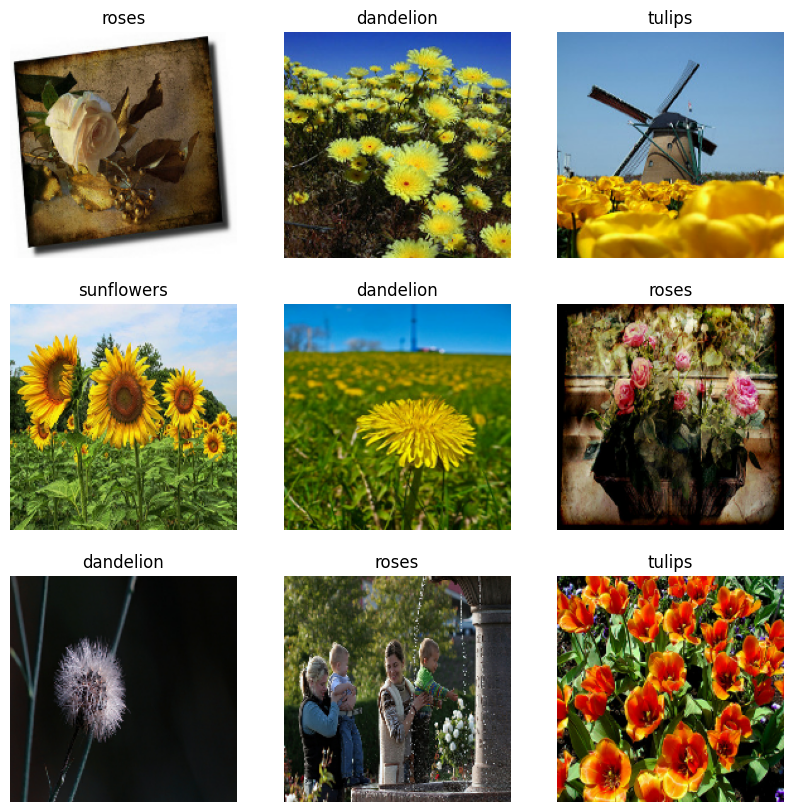

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터세트를 사용하는 모델을 `model.fit`(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

여기에서 `tf.keras.layers.Rescaling`을 사용하여 값을 `[0, 1]` 범위로 표준화합니다.

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. `Dataset.map`을 호출하여 데이터세트에 이를 적용할 수 있습니다.

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.96902645


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근법을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`로 조정하려면 대신 `tf.keras.layers.Rescaling(1./127.5, offset=-1)`을 작성할 수 있습니다.

참고: 이전에 `tf.keras.utils.image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 해당 모델에도 크기 조정 논리를 포함하려면 `tf.keras.layers.Resizing` 레이어를 사용할 수 있습니다.

### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 <a>tf.data API를 통한 성능 향상</a> 가이드의 <em>프리페치</em> 섹션에서 두 가지 메서드와 데이터를 디스크에 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 훈련하기

완성을 위해 방금 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다.

[순차](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 세 개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대해 자세히 알아보려면 [이미지 분류](../images/classification.ipynb) 튜토리얼을 방문하세요.

In [17]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

`tf.keras.optimizers.Adam` 옵티마이저 및 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달하세요.

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

참고: 몇 개의 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 5:37 - loss: 1.6192 - accuracy: 0.1562

 4/92 [>.............................] - ETA: 1s - loss: 1.6444 - accuracy: 0.2500  

 8/92 [=>............................] - ETA: 1s - loss: 1.6270 - accuracy: 0.2305

12/92 [==>...........................] - ETA: 1s - loss: 1.5605 - accuracy: 0.2995

16/92 [====>.........................] - ETA: 1s - loss: 1.5318 - accuracy: 0.3262

20/92 [=====>........................] - ETA: 1s - loss: 1.5153 - accuracy: 0.3297

24/92 [======>.......................] - ETA: 1s - loss: 1.4944 - accuracy: 0.3333

28/92 [========>.....................] - ETA: 1s - loss: 1.4716 - accuracy: 0.3482

32/92 [=========>....................] - ETA: 0s - loss: 1.4530 - accuracy: 0.3564

36/92 [==========>...................] - ETA: 0s - loss: 1.4205 - accuracy: 0.3715

40/92 [============>.................] - ETA: 0s - loss: 1.3976 - accuracy: 0.3891

44/92 [=============>................] - ETA: 0s - loss: 1.3754 - accuracy: 0.3984

48/92 [==============>...............] - ETA: 0s - loss: 1.3734 - accuracy: 0.4043

52/92 [===============>..............] - ETA: 0s - loss: 1.3631 - accuracy: 0.4062

56/92 [=================>............] - ETA: 0s - loss: 1.3530 - accuracy: 0.4090

60/92 [==================>...........] - ETA: 0s - loss: 1.3438 - accuracy: 0.4193

64/92 [===================>..........] - ETA: 0s - loss: 1.3290 - accuracy: 0.4307

68/92 [=====================>........] - ETA: 0s - loss: 1.3140 - accuracy: 0.4398

72/92 [======================>.......] - ETA: 0s - loss: 1.3021 - accuracy: 0.4449

76/92 [=======================>......] - ETA: 0s - loss: 1.3014 - accuracy: 0.4482

80/92 [=========================>....] - ETA: 0s - loss: 1.2963 - accuracy: 0.4508

84/92 [==========================>...] - ETA: 0s - loss: 1.2903 - accuracy: 0.4550

88/92 [===========================>..] - ETA: 0s - loss: 1.2866 - accuracy: 0.4577

92/92 [==============================] - ETA: 0s - loss: 1.2896 - accuracy: 0.4540

92/92 [==============================] - 6s 22ms/step - loss: 1.2896 - accuracy: 0.4540 - val_loss: 1.0886 - val_accuracy: 0.5777


Epoch 2/3


 1/92 [..............................] - ETA: 1s - loss: 1.0800 - accuracy: 0.6250

 5/92 [>.............................] - ETA: 1s - loss: 1.0733 - accuracy: 0.5625

 9/92 [=>............................] - ETA: 1s - loss: 1.0520 - accuracy: 0.5833

13/92 [===>..........................] - ETA: 1s - loss: 1.0284 - accuracy: 0.5673

17/92 [====>.........................] - ETA: 1s - loss: 1.0183 - accuracy: 0.5699

21/92 [=====>........................] - ETA: 1s - loss: 1.0170 - accuracy: 0.5774

25/92 [=======>......................] - ETA: 1s - loss: 1.0136 - accuracy: 0.5913

29/92 [========>.....................] - ETA: 1s - loss: 1.0133 - accuracy: 0.5927

33/92 [=========>....................] - ETA: 0s - loss: 1.0025 - accuracy: 0.5956

37/92 [===========>..................] - ETA: 0s - loss: 0.9913 - accuracy: 0.5988

41/92 [============>.................] - ETA: 0s - loss: 0.9823 - accuracy: 0.6029

45/92 [=============>................] - ETA: 0s - loss: 0.9875 - accuracy: 0.6021

49/92 [==============>...............] - ETA: 0s - loss: 0.9992 - accuracy: 0.5989

53/92 [================>.............] - ETA: 0s - loss: 1.0018 - accuracy: 0.5979

57/92 [=================>............] - ETA: 0s - loss: 1.0085 - accuracy: 0.5970

61/92 [==================>...........] - ETA: 0s - loss: 1.0081 - accuracy: 0.5999

65/92 [====================>.........] - ETA: 0s - loss: 1.0038 - accuracy: 0.6024

69/92 [=====================>........] - ETA: 0s - loss: 1.0005 - accuracy: 0.6033

73/92 [======================>.......] - ETA: 0s - loss: 0.9921 - accuracy: 0.6070

77/92 [========================>.....] - ETA: 0s - loss: 0.9906 - accuracy: 0.6088

81/92 [=========================>....] - ETA: 0s - loss: 0.9936 - accuracy: 0.6057

85/92 [==========================>...] - ETA: 0s - loss: 0.9928 - accuracy: 0.6085

89/92 [============================>.] - ETA: 0s - loss: 0.9982 - accuracy: 0.6060

92/92 [==============================] - 2s 18ms/step - loss: 1.0065 - accuracy: 0.6008 - val_loss: 1.0161 - val_accuracy: 0.6008


Epoch 3/3


 1/92 [..............................] - ETA: 1s - loss: 1.0035 - accuracy: 0.6562

 5/92 [>.............................] - ETA: 1s - loss: 0.9309 - accuracy: 0.6438

 9/92 [=>............................] - ETA: 1s - loss: 0.8984 - accuracy: 0.6562

13/92 [===>..........................] - ETA: 1s - loss: 0.8910 - accuracy: 0.6418

17/92 [====>.........................] - ETA: 1s - loss: 0.8846 - accuracy: 0.6415

21/92 [=====>........................] - ETA: 1s - loss: 0.8644 - accuracy: 0.6518

25/92 [=======>......................] - ETA: 1s - loss: 0.8649 - accuracy: 0.6575

29/92 [========>.....................] - ETA: 0s - loss: 0.8669 - accuracy: 0.6595

33/92 [=========>....................] - ETA: 0s - loss: 0.8546 - accuracy: 0.6648

37/92 [===========>..................] - ETA: 0s - loss: 0.8491 - accuracy: 0.6639

41/92 [============>.................] - ETA: 0s - loss: 0.8422 - accuracy: 0.6662

45/92 [=============>................] - ETA: 0s - loss: 0.8474 - accuracy: 0.6660

49/92 [==============>...............] - ETA: 0s - loss: 0.8571 - accuracy: 0.6601

53/92 [================>.............] - ETA: 0s - loss: 0.8576 - accuracy: 0.6616

57/92 [=================>............] - ETA: 0s - loss: 0.8627 - accuracy: 0.6606

61/92 [==================>...........] - ETA: 0s - loss: 0.8624 - accuracy: 0.6624

65/92 [====================>.........] - ETA: 0s - loss: 0.8573 - accuracy: 0.6654

69/92 [=====================>........] - ETA: 0s - loss: 0.8562 - accuracy: 0.6644

73/92 [======================>.......] - ETA: 0s - loss: 0.8515 - accuracy: 0.6670

77/92 [========================>.....] - ETA: 0s - loss: 0.8490 - accuracy: 0.6668

81/92 [=========================>....] - ETA: 0s - loss: 0.8480 - accuracy: 0.6686

85/92 [==========================>...] - ETA: 0s - loss: 0.8466 - accuracy: 0.6695

89/92 [============================>.] - ETA: 0s - loss: 0.8494 - accuracy: 0.6678

92/92 [==============================] - 2s 18ms/step - loss: 0.8589 - accuracy: 0.6642 - val_loss: 0.9884 - val_accuracy: 0.6240


참고: `Model.fit`을 사용하는 대신 사용자 지정 훈련 루프를 작성할 수도 있습니다. 자세히 알아보려면 [처음부터 훈련 루프 작성하기](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) 튜토리얼을 방문하세요.

검증 정확도가 훈련 정확도에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 이를 줄이는 방법에 대해 자세히 알아볼 수 있습니다.

## 미세 제어를 위해 `tf.data` 사용하기

위의 Keras 전처리 유틸리티 `tf.keras.utils.image_dataset_from_directory`는 이미지 디렉터리에서 `tf.data.Dataset`을 생성하는 편리한 방법입니다.

더 세밀한 제어를 위해 `tf.data`를 사용하여 고유한 입력 파이프라인을 작성할 수 있습니다. 이 섹션에서는 이전에 다운로드한 TGZ 파일의 파일 경로부터 시작하여 이를 수행하는 방법을 보여줍니다.

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/18237215308_a158d49f28_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/9200211647_be34ce978b.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/3518608454_c3fd3c311c_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/roses/5086249859_d066b37b8a_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/tulips/2418823693_72eec80f42_n.jpg'


파일의 트리 구조를 사용하여 `class_names` 목록을 컴파일할 수 있습니다.

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 학습 및 검증 세트로 분할합니다.

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

다음과 같이 각 데이터세트의 길이를 인쇄할 수 있습니다.

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 `(img, label)` 쌍으로 변환하는 간단한 함수를 작성합니다.

In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

`Dataset.map`을 사용하여 `image, label` 쌍의 데이터세트를 작성합니다.

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


### 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요합니다.

- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

이러한 기능은 `tf.data` API를 사용하여 추가할 수 있습니다. 자세한 내용은 [입력 파이프 라인 성능](../../guide/performance/datasets.ipynb) 가이드를 참조하세요.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 데이터 시각화하기

이 데이터세트를 이전에 작성한 데이터 세트와 유사하게 시각화할 수 있습니다.

2022-12-14 21:02:42.480684: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


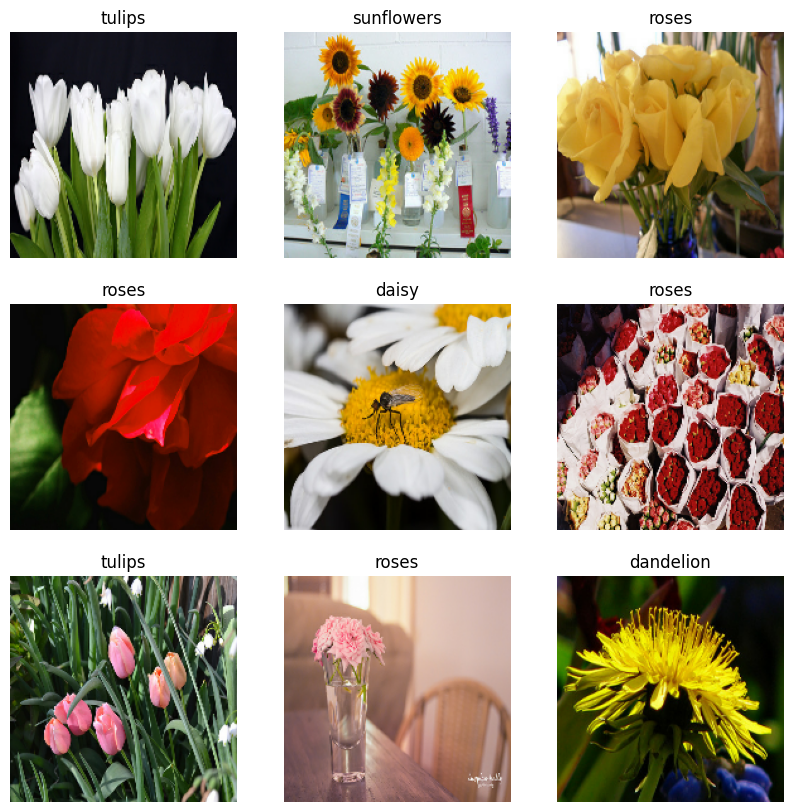

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### 모델 계속 훈련하기

이제 위의 `tf.keras.utils.image_dataset_from_directory`에 의해 생성된 것과 유사한 `tf.data.Dataset`을 수동으로 구축했습니다. 이를 사용하여 모델을 계속 학습할 수 있습니다. 이전과 마찬가지로 실행 시간을 짧게 유지하기 위해 몇 epoch 동안만 훈련합니다.

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 46s - loss: 0.9580 - accuracy: 0.5938

 5/92 [>.............................] - ETA: 1s - loss: 0.7986 - accuracy: 0.7063 

 9/92 [=>............................] - ETA: 1s - loss: 0.8021 - accuracy: 0.7118

13/92 [===>..........................] - ETA: 1s - loss: 0.7932 - accuracy: 0.7043

17/92 [====>.........................] - ETA: 1s - loss: 0.8266 - accuracy: 0.6820

21/92 [=====>........................] - ETA: 1s - loss: 0.8254 - accuracy: 0.6815

25/92 [=======>......................] - ETA: 1s - loss: 0.8119 - accuracy: 0.6875

29/92 [========>.....................] - ETA: 1s - loss: 0.8096 - accuracy: 0.6897

33/92 [=========>....................] - ETA: 0s - loss: 0.8028 - accuracy: 0.6951

37/92 [===========>..................] - ETA: 0s - loss: 0.8047 - accuracy: 0.6943

41/92 [============>.................] - ETA: 0s - loss: 0.8058 - accuracy: 0.6959

45/92 [=============>................] - ETA: 0s - loss: 0.8002 - accuracy: 0.6979

49/92 [==============>...............] - ETA: 0s - loss: 0.7885 - accuracy: 0.6983

53/92 [================>.............] - ETA: 0s - loss: 0.7854 - accuracy: 0.6999

57/92 [=================>............] - ETA: 0s - loss: 0.7802 - accuracy: 0.7018

61/92 [==================>...........] - ETA: 0s - loss: 0.7742 - accuracy: 0.7065

65/92 [====================>.........] - ETA: 0s - loss: 0.7799 - accuracy: 0.7053

69/92 [=====================>........] - ETA: 0s - loss: 0.7766 - accuracy: 0.7043

73/92 [======================>.......] - ETA: 0s - loss: 0.7764 - accuracy: 0.7042

77/92 [========================>.....] - ETA: 0s - loss: 0.7782 - accuracy: 0.7033

81/92 [=========================>....] - ETA: 0s - loss: 0.7765 - accuracy: 0.7064

85/92 [==========================>...] - ETA: 0s - loss: 0.7823 - accuracy: 0.7029

89/92 [============================>.] - ETA: 0s - loss: 0.7783 - accuracy: 0.7044

92/92 [==============================] - 2s 21ms/step - loss: 0.7816 - accuracy: 0.7023 - val_loss: 0.7103 - val_accuracy: 0.7153


Epoch 2/3


 1/92 [..............................] - ETA: 1s - loss: 0.6525 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 1s - loss: 0.6807 - accuracy: 0.7437

 9/92 [=>............................] - ETA: 1s - loss: 0.6501 - accuracy: 0.7604

13/92 [===>..........................] - ETA: 1s - loss: 0.6462 - accuracy: 0.7572

17/92 [====>.........................] - ETA: 1s - loss: 0.6096 - accuracy: 0.7721

21/92 [=====>........................] - ETA: 1s - loss: 0.6407 - accuracy: 0.7589

25/92 [=======>......................] - ETA: 1s - loss: 0.6337 - accuracy: 0.7575

29/92 [========>.....................] - ETA: 1s - loss: 0.6329 - accuracy: 0.7522

33/92 [=========>....................] - ETA: 0s - loss: 0.6240 - accuracy: 0.7566

37/92 [===========>..................] - ETA: 0s - loss: 0.6253 - accuracy: 0.7568

41/92 [============>.................] - ETA: 0s - loss: 0.6253 - accuracy: 0.7546

45/92 [=============>................] - ETA: 0s - loss: 0.6271 - accuracy: 0.7556

49/92 [==============>...............] - ETA: 0s - loss: 0.6314 - accuracy: 0.7538

53/92 [================>.............] - ETA: 0s - loss: 0.6265 - accuracy: 0.7594

57/92 [=================>............] - ETA: 0s - loss: 0.6269 - accuracy: 0.7593

61/92 [==================>...........] - ETA: 0s - loss: 0.6255 - accuracy: 0.7613

65/92 [====================>.........] - ETA: 0s - loss: 0.6229 - accuracy: 0.7606

69/92 [=====================>........] - ETA: 0s - loss: 0.6219 - accuracy: 0.7627

73/92 [======================>.......] - ETA: 0s - loss: 0.6239 - accuracy: 0.7628

77/92 [========================>.....] - ETA: 0s - loss: 0.6225 - accuracy: 0.7638

81/92 [=========================>....] - ETA: 0s - loss: 0.6210 - accuracy: 0.7643

85/92 [==========================>...] - ETA: 0s - loss: 0.6252 - accuracy: 0.7610

89/92 [============================>.] - ETA: 0s - loss: 0.6267 - accuracy: 0.7616

92/92 [==============================] - 2s 18ms/step - loss: 0.6251 - accuracy: 0.7629 - val_loss: 0.7505 - val_accuracy: 0.7139


Epoch 3/3


 1/92 [..............................] - ETA: 1s - loss: 0.5542 - accuracy: 0.8125

 5/92 [>.............................] - ETA: 1s - loss: 0.5501 - accuracy: 0.8188

 9/92 [=>............................] - ETA: 1s - loss: 0.5067 - accuracy: 0.8229

13/92 [===>..........................] - ETA: 1s - loss: 0.5106 - accuracy: 0.8221

17/92 [====>.........................] - ETA: 1s - loss: 0.4887 - accuracy: 0.8364

21/92 [=====>........................] - ETA: 1s - loss: 0.4843 - accuracy: 0.8378

25/92 [=======>......................] - ETA: 1s - loss: 0.4796 - accuracy: 0.8363

29/92 [========>.....................] - ETA: 1s - loss: 0.4660 - accuracy: 0.8373

33/92 [=========>....................] - ETA: 0s - loss: 0.4643 - accuracy: 0.8362

37/92 [===========>..................] - ETA: 0s - loss: 0.4497 - accuracy: 0.8404

41/92 [============>.................] - ETA: 0s - loss: 0.4397 - accuracy: 0.8445

45/92 [=============>................] - ETA: 0s - loss: 0.4426 - accuracy: 0.8410

49/92 [==============>...............] - ETA: 0s - loss: 0.4337 - accuracy: 0.8438

53/92 [================>.............] - ETA: 0s - loss: 0.4342 - accuracy: 0.8443

57/92 [=================>............] - ETA: 0s - loss: 0.4406 - accuracy: 0.8405

61/92 [==================>...........] - ETA: 0s - loss: 0.4336 - accuracy: 0.8422

65/92 [====================>.........] - ETA: 0s - loss: 0.4325 - accuracy: 0.8433

69/92 [=====================>........] - ETA: 0s - loss: 0.4359 - accuracy: 0.8419

73/92 [======================>.......] - ETA: 0s - loss: 0.4378 - accuracy: 0.8399

77/92 [========================>.....] - ETA: 0s - loss: 0.4380 - accuracy: 0.8417

81/92 [=========================>....] - ETA: 0s - loss: 0.4339 - accuracy: 0.8430

85/92 [==========================>...] - ETA: 0s - loss: 0.4317 - accuracy: 0.8434

89/92 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.8427

92/92 [==============================] - 2s 18ms/step - loss: 0.4344 - accuracy: 0.8423 - val_loss: 0.8368 - val_accuracy: 0.7112


## TensorFlow 데이터세트 사용하기

지금까지 이 튜토리얼은 디스크에서 데이터를 로드하는 데 중점을 두었습니다. [TensorFlow Datasets](https://www.tensorflow.org/datasets)에서 다운로드하기 쉬운 대규모 데이터세트 [카탈로그](https://www.tensorflow.org/datasets/catalog/overview)를 탐색하여 사용할 데이터세트를 찾을 수도 있습니다.

이전에 디스크에서 꽃 데이터세트를 로드했으므로 이제 TensorFlow 데이터세트로 가져오겠습니다.

TensorFlow 데이터세트를 사용하여 꽃 [데이터세트](https://www.tensorflow.org/datasets/catalog/tf_flowers)를 다운로드합니다.

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

꽃 데이터세트에는 5가지 클래스가 있습니다.

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색합니다.

2022-12-14 21:02:50.993018: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


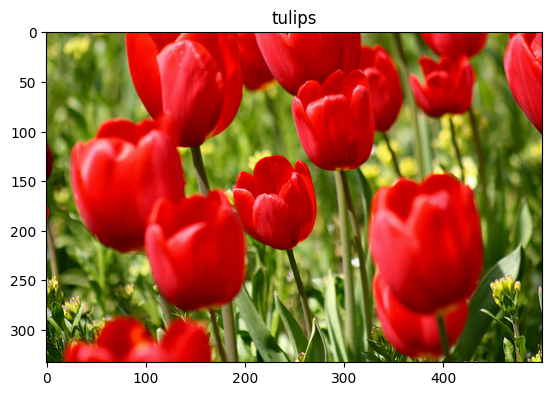

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

이전과 마찬가지로 성능을 위해 훈련, 검증 및 테스트 세트를 일괄 처리, 셔플 및 구성해야 합니다.

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

[데이터 강화](../images/data_augmentation.ipynb) 가이드를 방문하여 꽃 데이터세트 및 TensorFlow 데이터세트를 처리하는 전체 예제를 찾을 수 있습니다.

## 다음 단계

이 튜토리얼에서는 디스크에서 이미지를 로드하는 두 가지 방법을 보여주었습니다. 먼저 Keras 사전 처리 레이어 및 유틸리티를 사용하여 이미지 데이터세트를 로드하고 사전 처리하는 방법을 배웠습니다. 다음으로 `tf.data`를 사용하여 처음부터 입력 파이프라인을 작성하는 방법을 배웠습니다. 마지막으로 TensorFlow Datasets에서 데이터세트를 다운로드하는 방법을 배웠습니다.

다음 단계:

- [데이터 증강을 추가하는 방법](https://www.tensorflow.org/tutorials/images/data_augmentation)을 배울 수 있습니다.
- `tf.data`에 대해 자세히 알아보려면 [tf.data: Build TensorFlow 입력 파이프라인](https://www.tensorflow.org/guide/data) 가이드를 방문하세요.